## 使用块的网络 VGG

虽然AlexNet证明深层神经网络卓有成效，但它没有提供一个通用的模板来指导后续的研究人员设计新的网络。我们需要把框架搞得更regular一点。在下面的几个章节中，我们将介绍一些常用于设计深层神经网络的启发式概念。
- AlexNet比LeNet更深更大，来达到更好的精度；
- 选项：
  - 使用更多全连接层（太贵）
  - 更多卷积层
  - 将卷积层组合成块，模块化思想

### 1、VGG块

深但窄，比浅但宽要好；
VGG块：
- $3\times 3$卷积，填充为1（保持形状）；n层，in_channels和out_channels交替；
- $2\times 2$最大池化，步幅为2。

In [1]:
import torch
from torch import nn
import sys
sys.path.append('..')
import utils
import d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [4]:
def test(*args):
    for idx, arg in enumerate(args):
        print(f'{idx}, {arg}')

x = [1,2,3,4]
test(*x)

0, 1
1, 2
2, 3
3, 4


### 2、VGG网络

仍然类似AlexNet和LeNet，有两部分：第一部分主要是卷积和池化，第二部分为全连接层；
- 多个VGG块后接全连接层；
- 不同次数的重复块，得到不同的架构：VGG-16、VGG-19、……

<img src='https://zh-v2.d2l.ai/_images/vgg.svg' style="zoom:60%;" />

其中有超参数变量conv_arch。该变量指定了（每个VGG块里卷积层个数, 输出通道数），网络的输入通道数则是指定好的。全连接模块则与AlexNet中的相同，也是指定好的。

In [5]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

In [6]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1                                 # 用的是Fashion-MNIST，所以单通道输入
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),      # 7 = 224 / 32，32 = 2^5，因为是5个VGG块
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [7]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.162, train acc 0.939, test acc 0.922
588.0 examples/sec on cuda:3


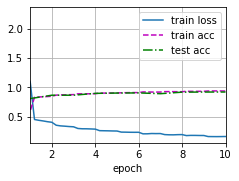

In [11]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, '../data', resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, utils.try_gpu(3))

### 3、小结

- VGG使用可重复使用的卷积块，来简洁定义深度卷积神经网络；
- 不同卷积快个数和超参数，可以得到不同复杂度的变种；比如复杂的用来刷榜，简化的拿来部署；
- 发现深层且窄的卷积（即$3\times 3$）比较浅层且宽的卷积更有效。